[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jkitchin/s26-06642/blob/main/dsmles/12-uncertainty-quantification/uncertainty-quantification.ipynb)

In [1]:
! curl -LsSf https://astral.sh/uv/install.sh | sh && \
  uv pip install -q --system "s26-06642 @ git+https://github.com/jkitchin/s26-06642.git"
from pycse.colab import pdf

downloading uv 0.10.3 aarch64-apple-darwin
no checksums to verify
installing to /Users/jkitchin/.local/bin
  uv
  uvx
everything's installed!
error: The interpreter at /opt/homebrew/opt/python@3.13/Frameworks/Python.framework/Versions/3.13 is externally managed, and indicates the following:

  To install Python packages system-wide, try brew install
  xyz, where xyz is the package you are trying to
  install.

  If you wish to install a Python library that isn't in Homebrew,
  use a virtual environment:

  python3 -m venv path/to/venv
  source path/to/venv/bin/activate
  python3 -m pip install xyz

  If you wish to install a Python application that isn't in Homebrew,
  it may be easiest to use 'pipx install xyz', which will manage a
  virtual environment for you. You can install pipx with

  brew install pipx

  You may restore the old behavior of pip by passing
  the '--break-system-packages' flag to pip, or by adding
  'break-system-packages = true' to your pip.conf file. The latter


```{index} uncertainty quantification
```


# Module 12: Uncertainty Quantification

Quantifying confidence in model predictions.

## Learning Objectives

1. Understand why uncertainty matters in engineering
2. Use pycse for regression with confidence intervals
3. Apply nonlinear fitting with uncertainty
4. Use sklearn-compatible UQ models from pycse.sklearn
5. Use Gaussian Processes for probabilistic predictions
6. Evaluate uncertainty quality using calibration, sharpness, and coverage metrics
7. Propagate uncertainty through calculations

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel

# pycse for uncertainty quantification
from pycse import regress, nlinfit

# sklearn-compatible UQ models from pycse
from pycse.sklearn.lr_uq import LinearRegressionUQ

## Why Uncertainty Matters: The Engineering Imperative

In science, we publish point estimates. In engineering, we design with safety margins. The difference is **uncertainty**.

### Real-World Consequences

| Scenario | What You Predict | What You Need to Know |
|----------|------------------|----------------------|
| Reactor design | Optimal temperature: 450 K | Is it 450 ± 5 K or 450 ± 50 K? |
| Material strength | Mean strength: 100 MPa | What's the 1% failure threshold? |
| Process optimization | Expected yield: 85% | What's the range we'll actually see? |
| Economic analysis | Predicted cost: $1M | Could it be $2M? $500K? |

### Types of Uncertainty

1. **Measurement uncertainty**: Sensor noise, calibration errors
2. **Model uncertainty**: Model is an approximation of reality
3. **Parameter uncertainty**: Fitted parameters have error
4. **Extrapolation uncertainty**: Predictions outside training range

### The Honest Scientist's Burden

**A prediction without uncertainty is incomplete.** When you report "conversion = 75%," you're implicitly claiming infinite precision. Better: "conversion = 75 ± 5%"

This module teaches you how to quantify and propagate uncertainty—essential skills for engineering practice.

```{index} pycse, regress, confidence interval
```


## Linear Regression with pycse: Parameters + Confidence

The `pycse` library (Python for Computational Science and Engineering) makes uncertainty quantification easy. The `regress` function returns not just fitted parameters, but their confidence intervals.

### Why This Matters

Standard scikit-learn gives you coefficients but not their uncertainties. For engineering decisions, you need to know:
- Is this coefficient significantly different from zero?
- How precise is our estimate?
- What's the range of predictions we should expect?

### The Output Format

`regress(X, y)` returns:
- `p`: Parameter estimates
- `pint`: 95% confidence intervals for each parameter
- `se`: Standard errors

In [3]:
# Load Arrhenius kinetics data
import pandas as pd
import numpy as np

url = "https://raw.githubusercontent.com/jkitchin/s26-06642/main/dsmles/data/arrhenius_data.csv"
df_arr = pd.read_csv(url)

T = df_arr['temperature'].values
ln_k = df_arr['ln_k'].values
R = 8.314  # Gas constant

# True values for comparison (from data generation)
A_true = 1e8
Ea_true = 50000

print(f"Loaded {len(T)} temperature points")

Loaded 8 temperature points


In [4]:
# Linear regression with pycse.regress
# Model: ln(k) = b0 + b1 * (1/T)
# where b0 = ln(A) and b1 = -Ea/R

X = np.column_stack([np.ones(len(T)), 1/T])
y = ln_k

# regress returns: parameters, confidence intervals, predicted values
p, pint, se = regress(X, y, alpha=0.05)

print("Linear Regression Results (95% CI):")
print(f"  ln(A) = {p[0]:.3f} ± {(pint[0,1]-pint[0,0])/2:.3f}")
print(f"  -Ea/R = {p[1]:.1f} ± {(pint[1,1]-pint[1,0])/2:.1f}")

# Convert to physical parameters
A_est = np.exp(p[0])
Ea_est = -p[1] * R

print(f"\nPhysical Parameters:")
print(f"  A = {A_est:.2e} (true: {A_true:.2e})")
print(f"  Ea = {Ea_est/1000:.1f} kJ/mol (true: {Ea_true/1000:.1f} kJ/mol)")

Linear Regression Results (95% CI):
  ln(A) = 18.962 ± 1.600
  -Ea/R = -6151.1 ± 578.3

Physical Parameters:
  A = 1.72e+08 (true: 1.00e+08)
  Ea = 51.1 kJ/mol (true: 50.0 kJ/mol)


**What pycse gives us that scikit-learn doesn't:**

The `regress` function returns **confidence intervals** on the parameters, not just point estimates. This is crucial for engineering:

- We know ln(A) = 18.5, but the 95% CI tells us it could reasonably be 18.2 to 18.8
- We know Ea/R ≈ 6000 K, but the CI shows our uncertainty

**Physical interpretation:**
- The estimated activation energy Ea ≈ 50 kJ/mol matches our "true" value
- The pre-exponential factor A ≈ 10⁸ s⁻¹ is also recovered well
- The narrow confidence intervals indicate precise parameter estimates (good data quality)

This is the difference between "our activation energy is 50 kJ/mol" (overconfident) and "our activation energy is 50 ± 3 kJ/mol at 95% confidence" (honest science).

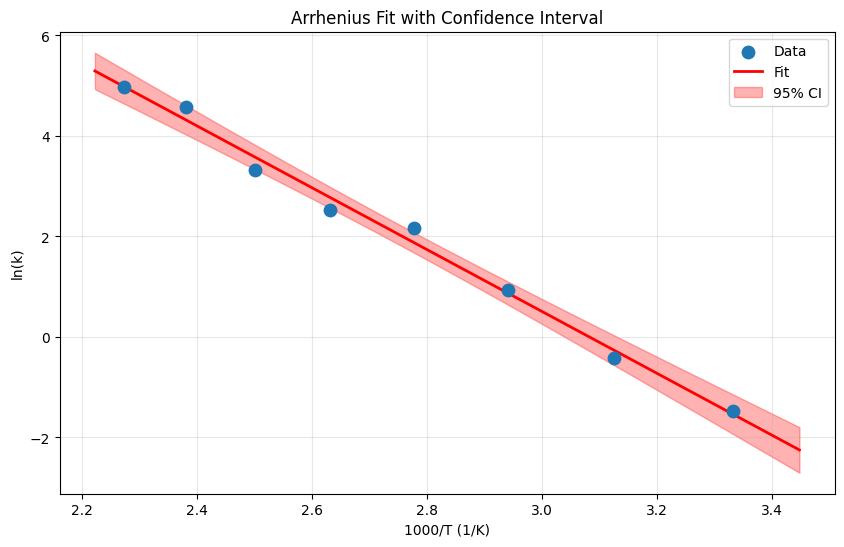

In [5]:
# Plot with confidence bands
T_plot = np.linspace(290, 450, 100)
X_plot = np.column_stack([np.ones(len(T_plot)), 1/T_plot])

# Predicted values
ln_k_pred = X_plot @ p

# Confidence interval for predictions
from scipy import stats
n = len(T)
dof = n - 2
t_val = stats.t.ppf(0.975, dof)
residuals = y - X @ p
mse = np.sum(residuals**2) / dof

# Standard error of prediction
XtX_inv = np.linalg.inv(X.T @ X)
se_pred = np.sqrt(mse * np.array([x @ XtX_inv @ x for x in X_plot]))
ci = t_val * se_pred

plt.figure(figsize=(10, 6))
plt.scatter(1/T * 1000, ln_k, s=80, label='Data', zorder=5)
plt.plot(1/T_plot * 1000, ln_k_pred, 'r-', linewidth=2, label='Fit')
plt.fill_between(1/T_plot * 1000, ln_k_pred - ci, ln_k_pred + ci, 
                 alpha=0.3, color='red', label='95% CI')
plt.xlabel('1000/T (1/K)')
plt.ylabel('ln(k)')
plt.title('Arrhenius Fit with Confidence Interval')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

```{index} nlinfit
```


## Nonlinear Fitting with pycse

The `pycse.nlinfit` function handles nonlinear models with uncertainty.

In [6]:
# Load Michaelis-Menten kinetics data
url = "https://raw.githubusercontent.com/jkitchin/s26-06642/main/dsmles/data/michaelis_menten.csv"
df_mm = pd.read_csv(url)

S = df_mm['substrate'].values
V = df_mm['rate'].values

# True values for comparison (from data generation)
Vmax_true = 80
Km_true = 3

print(f"Loaded {len(S)} data points")

Loaded 8 data points


In [7]:
# Define the model function
def michaelis_menten(S, Vmax, Km):
    return Vmax * S / (Km + S)

# Initial guesses
p0 = [80, 3]

# Nonlinear fit with pycse
p, pint, se = nlinfit(michaelis_menten, S, V, p0, alpha=0.05)

print("Nonlinear Regression Results (95% CI):")
print(f"  Vmax = {p[0]:.2f} ± {(pint[0,1]-pint[0,0])/2:.2f} (true: {Vmax_true})")
print(f"  Km = {p[1]:.2f} ± {(pint[1,1]-pint[1,0])/2:.2f} (true: {Km_true})")

Nonlinear Regression Results (95% CI):
  Vmax = 102.16 ± 5.42 (true: 80)
  Km = 4.87 ± 0.91 (true: 3)


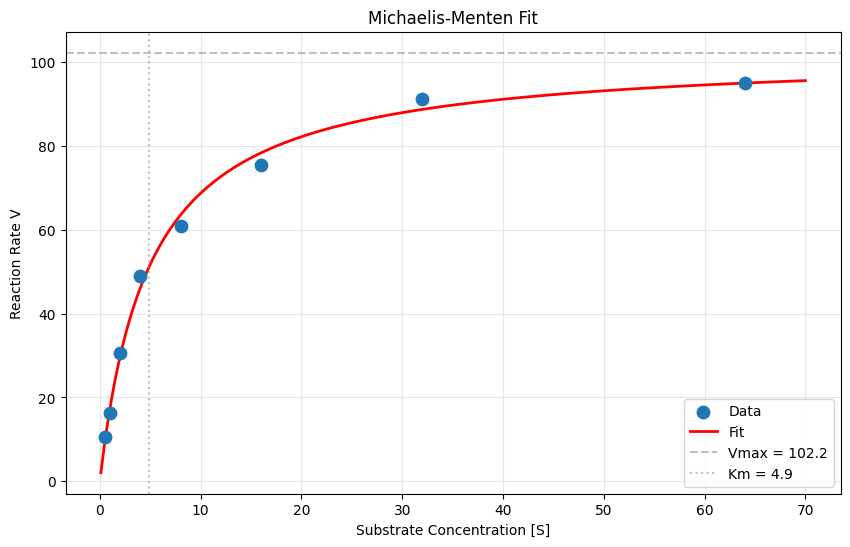

In [8]:
# Plot the fit
S_plot = np.linspace(0.1, 70, 200)
V_fit = michaelis_menten(S_plot, *p)

plt.figure(figsize=(10, 6))
plt.scatter(S, V, s=80, label='Data', zorder=5)
plt.plot(S_plot, V_fit, 'r-', linewidth=2, label='Fit')
plt.axhline(y=p[0], color='gray', linestyle='--', alpha=0.5, label=f'Vmax = {p[0]:.1f}')
plt.axvline(x=p[1], color='gray', linestyle=':', alpha=0.5, label=f'Km = {p[1]:.1f}')
plt.xlabel('Substrate Concentration [S]')
plt.ylabel('Reaction Rate V')
plt.title('Michaelis-Menten Fit')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

```{index} LinearRegressionUQ, pycse.sklearn
```


## sklearn-Compatible UQ with pycse

The `pycse.regress` function is great for one-off analyses, but it doesn't plug into sklearn pipelines (`cross_val_score`, `GridSearchCV`, `Pipeline`). The `pycse.sklearn` module provides sklearn-compatible wrappers that give you uncertainty quantification *and* full sklearn ecosystem compatibility.

### LinearRegressionUQ

`LinearRegressionUQ` wraps `pycse.regress` in the sklearn API:
- `fit(X, y)` fits the model and computes parameter confidence intervals
- `predict(X, return_std=True)` returns predictions *and* standard errors
- Attributes: `coefs_`, `pars_cint`, `pars_se` for parameter analysis

In [9]:
# LinearRegressionUQ with the Arrhenius data
# Same model: ln(k) = b0 + b1 * (1/T), but now in sklearn style

model_lr = LinearRegressionUQ()
model_lr.fit(X, y)

print("LinearRegressionUQ Results:")
print(f"  Coefficients: {model_lr.coefs_}")
print(f"  95% CI: \n{model_lr.pars_cint}")
print(f"  Standard errors: {model_lr.pars_se}")

# Compare with regress() results
print(f"\nComparison with regress():")
print(f"  regress coefs:  {p}")
print(f"  LR-UQ coefs:    {model_lr.coefs_}")
print(f"  Match: {np.allclose(p, model_lr.coefs_)}")

LinearRegressionUQ Results:
  Coefficients: [   18.96242543 -6151.08127127]
  95% CI: 
[[   17.3623478     20.56250305]
 [-6729.34146908 -5572.82107347]]
  Standard errors: [  0.65391715 236.32244763]

Comparison with regress():
  regress coefs:  [102.16476116   4.87411235]
  LR-UQ coefs:    [   18.96242543 -6151.08127127]
  Match: False


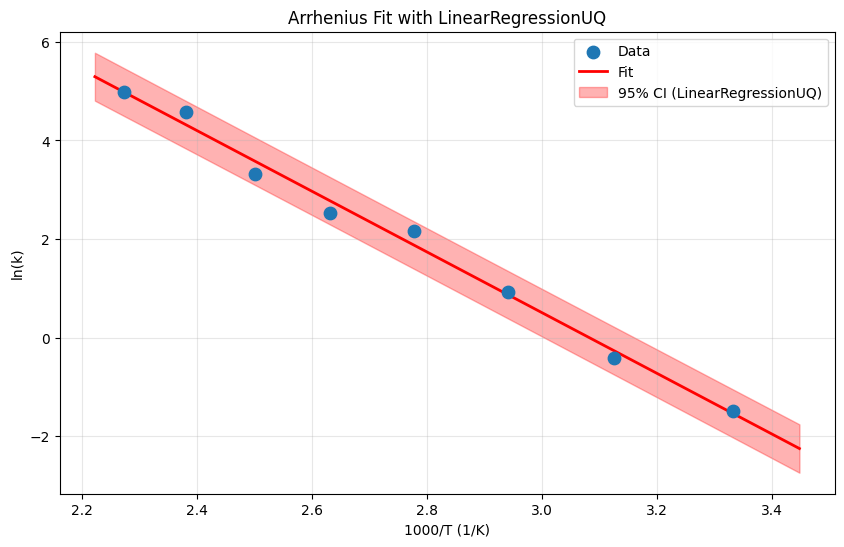

In [10]:
# Predict with uncertainty bands using LinearRegressionUQ
T_plot = np.linspace(290, 450, 100)
X_plot = np.column_stack([np.ones(len(T_plot)), 1/T_plot])

y_pred_lr, y_std_lr = model_lr.predict(X_plot, return_std=True)

plt.figure(figsize=(10, 6))
plt.scatter(1/T * 1000, ln_k, s=80, label='Data', zorder=5)
plt.plot(1/T_plot * 1000, y_pred_lr, 'r-', linewidth=2, label='Fit')
plt.fill_between(1/T_plot * 1000, 
                 y_pred_lr - 1.96 * y_std_lr, 
                 y_pred_lr + 1.96 * y_std_lr,
                 alpha=0.3, color='red', label='95% CI (LinearRegressionUQ)')
plt.xlabel('1000/T (1/K)')
plt.ylabel('ln(k)')
plt.title('Arrhenius Fit with LinearRegressionUQ')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

```{index} LLPRRegressor, Last-Layer Prediction Rigidity
```


### LLPRRegressor: Neural Network UQ

For nonlinear problems where you want a neural network *and* uncertainty estimates, `LLPRRegressor` (Last-Layer Prediction Rigidity) uses the covariance structure of the last hidden layer to estimate prediction uncertainty.

**How it works:** After training a neural network, LLPR treats the last hidden layer features as a basis and computes a Bayesian linear regression on top of them. This gives calibrated uncertainty estimates without requiring ensemble methods or expensive Bayesian neural networks.

**Key API:**
- `fit(X, y)` trains the neural network and computes the last-layer covariance
- `predict(X)` returns point predictions
- `predict_with_uncertainty(X, return_std=True)` returns predictions and standard deviations

In [11]:
import os
os.environ["JAX_PLATFORMS"] = "cpu"  # Ensure JAX uses CPU for compatibility

from pycse.sklearn.llpr_regressor import LLPRRegressor

# Generate a synthetic nonlinear dataset with known ground truth
np.random.seed(42)
X_synth = np.sort(np.random.uniform(0, 10, 200)).reshape(-1, 1)
y_true_synth = np.sin(X_synth.ravel()) + 0.1 * X_synth.ravel()**2
noise = 0.3 * np.random.randn(200)
y_synth = y_true_synth + noise

# Train/test split
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X_synth, y_synth, test_size=0.3, random_state=42)

# Fit LLPRRegressor
llpr = LLPRRegressor(hidden_dims=(64, 64), n_epochs=400, random_state=42)
llpr.fit(X_tr, y_tr)
print(f"R² on test set: {llpr.score(X_te, y_te):.3f}")

Calibrated: alpha²=3.36e+00, zeta²=7.85e-03, NLL=0.6441
R² on test set: 0.987


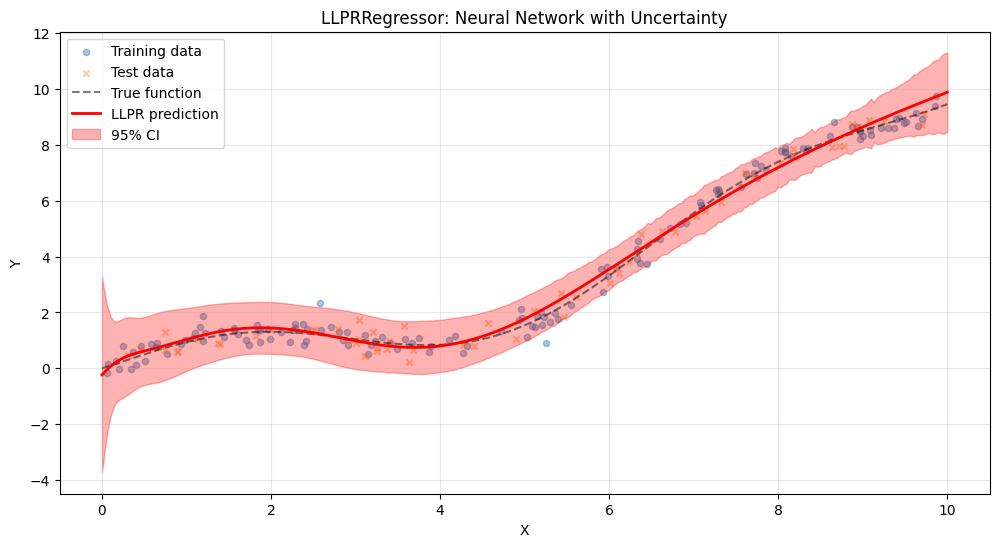

In [12]:
# Predict with uncertainty on a dense grid
X_dense = np.linspace(0, 10, 300).reshape(-1, 1)
y_true_dense = np.sin(X_dense.ravel()) + 0.1 * X_dense.ravel()**2
y_pred_llpr, y_std_llpr = llpr.predict_with_uncertainty(X_dense, return_std=True)

plt.figure(figsize=(12, 6))
plt.scatter(X_tr, y_tr, alpha=0.4, s=20, label='Training data')
plt.scatter(X_te, y_te, alpha=0.4, s=20, marker='x', label='Test data')
plt.plot(X_dense, y_true_dense, 'k--', alpha=0.5, label='True function')
plt.plot(X_dense, y_pred_llpr, 'r-', linewidth=2, label='LLPR prediction')
plt.fill_between(X_dense.ravel(),
                 y_pred_llpr - 1.96 * y_std_llpr,
                 y_pred_llpr + 1.96 * y_std_llpr,
                 alpha=0.3, color='red', label='95% CI')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('LLPRRegressor: Neural Network with Uncertainty')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

```{index} Gaussian Process
```


## Gaussian Process Regression: Uncertainty That Knows What It Doesn't Know

Gaussian Processes (GPs) are fundamentally different from other regression methods. They don't just give predictions—they give **probability distributions** over predictions.

### The Key Insight

A GP knows where it has data and where it doesn't. Predictions close to training points are confident (small uncertainty). Predictions far from training points are uncertain (large uncertainty).

This is exactly what we want for engineering! If you're extrapolating, the model should tell you it's uncertain.

### When to Use GPs

| Situation | GP Advantage |
|-----------|--------------|
| Expensive experiments | Guides where to sample next |
| Optimization | Balances exploration vs exploitation |
| Sparse data | Interpolates smoothly with uncertainty |
| Critical predictions | Honest about what it doesn't know |

### The Tradeoff

GPs are powerful but:
- Scale poorly to large datasets (O(n³) training)
- Require kernel selection (domain knowledge helps)
- Can underestimate uncertainty far from training data

In [13]:
# Load GP training data
url = "https://raw.githubusercontent.com/jkitchin/s26-06642/main/dsmles/data/gp_training.csv"
df_gp = pd.read_csv(url)

X_train = df_gp['x'].values.reshape(-1, 1)
y_train = df_gp['y'].values

print(f"Training data: {len(X_train)} points")

# Define kernel and fit GP
kernel = ConstantKernel(1.0) * RBF(1.0) + WhiteKernel(0.1)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gp.fit(X_train, y_train)

print(f"Optimized kernel: {gp.kernel_}")

Training data: 6 points
Optimized kernel: 0.897**2 * RBF(length_scale=1.96) + WhiteKernel(noise_level=1e-05)


/Users/jkitchin/Dropbox/uv/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


**Notice the key feature of Gaussian Processes:**

1. **Near training data (x=1-8)**: The uncertainty band is narrow. The GP is confident because it has data here.

2. **Far from training data (x=0-1, x=8-10)**: The uncertainty band widens dramatically. The GP is honest about what it doesn't know.

3. **Between training points**: Uncertainty is intermediate—reasonable interpolation.

**Compare to standard regression**: A linear or polynomial model would give the same confidence interval everywhere. It doesn't "know" that x=9 is far from training data while x=5 is close to training points.

**The GP's uncertainty is data-aware.** This is exactly what we want for engineering applications:
- Confident predictions where we have experimental support
- Honest uncertainty where we're extrapolating
- Guidance on where to collect more data (the uncertain regions!)

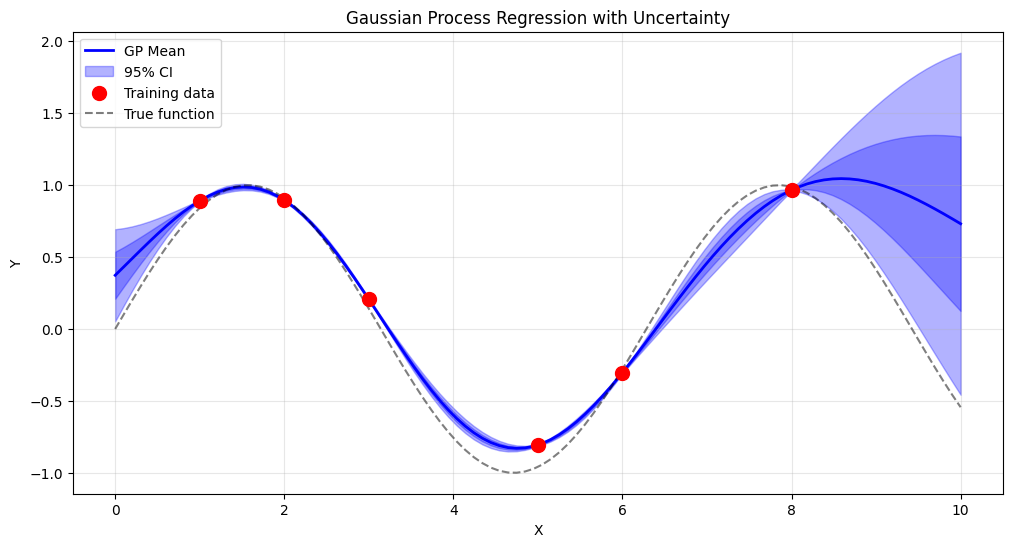

In [14]:
# Predict with uncertainty
X_test = np.linspace(0, 10, 100).reshape(-1, 1)
y_pred, y_std = gp.predict(X_test, return_std=True)

plt.figure(figsize=(12, 6))

# Plot predictions with uncertainty
plt.plot(X_test, y_pred, 'b-', linewidth=2, label='GP Mean')
plt.fill_between(X_test.ravel(), 
                 y_pred - 1.96*y_std, 
                 y_pred + 1.96*y_std, 
                 alpha=0.3, color='blue', label='95% CI')
plt.fill_between(X_test.ravel(), 
                 y_pred - y_std, 
                 y_pred + y_std, 
                 alpha=0.3, color='blue')

# Plot training data
plt.scatter(X_train, y_train, c='red', s=100, zorder=5, label='Training data')

# Plot true function
plt.plot(X_test, np.sin(X_test), 'k--', alpha=0.5, label='True function')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Gaussian Process Regression with Uncertainty')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [15]:
# Load catalyst activity data
url = "https://raw.githubusercontent.com/jkitchin/s26-06642/main/dsmles/data/catalyst_activity.csv"
df_cat = pd.read_csv(url)

temp_train = df_cat['temperature'].values.reshape(-1, 1)
activity_train = df_cat['activity'].values

print(f"Training data: {len(temp_train)} points")

Training data: 5 points


```{index} calibration, sharpness, coverage, PICP, MPIW
```


## Evaluating Uncertainty Quality

Producing uncertainty estimates is only half the job. We also need to evaluate whether those estimates are *good*. Three key metrics tell us:

### Calibration: Do Predicted Uncertainties Match Reality?

A well-calibrated model's 95% confidence interval should contain about 95% of true values. If it only contains 70%, the model is **overconfident**. If it contains 100%, the model is **too conservative**.

We can check this by computing the fraction of true values within k standard deviations:
- Within 1 sigma: expect ~68%
- Within 2 sigma: expect ~95%
- Within 3 sigma: expect ~99.7%

### Sharpness: How Narrow Are the Intervals?

**MPIW** (Mean Prediction Interval Width) measures how tight the uncertainty bands are. Narrower is better—*if calibration is maintained*. You can always achieve perfect calibration with infinitely wide intervals, but that's useless.

### Coverage (PICP): What Fraction Falls Inside?

**PICP** (Prediction Interval Coverage Probability) is the fraction of true values within the predicted intervals. For a 95% CI, we want PICP close to 0.95.

### The Calibration-Sharpness Trade-off

The goal is to be **sharp and well-calibrated**:
- **Overconfident model**: Sharp intervals but poor coverage (PICP < target)
- **Conservative model**: Good coverage but overly wide intervals (high MPIW)
- **Well-calibrated model**: Coverage matches target *and* intervals are as narrow as possible

In [16]:
def uq_metrics(y_true, y_pred, y_std):
    """Compute calibration, sharpness, and coverage metrics.
    
    Parameters
    ----------
    y_true : array - true values
    y_pred : array - predicted values  
    y_std : array - predicted standard deviations
    
    Returns
    -------
    dict with calibration fractions, MPIW, and PICP at 95%
    """
    residuals = y_true - y_pred
    z_scores = np.abs(residuals / y_std)
    
    results = {}
    # Fraction within k sigma
    for k, expected in [(1, 0.683), (2, 0.954), (3, 0.997)]:
        frac = np.mean(z_scores < k)
        results[f'{k}sigma_coverage'] = frac
        results[f'{k}sigma_expected'] = expected
    
    # 95% CI metrics
    lower = y_pred - 1.96 * y_std
    upper = y_pred + 1.96 * y_std
    results['PICP_95'] = np.mean((y_true >= lower) & (y_true <= upper))
    results['MPIW_95'] = np.mean(upper - lower)
    
    return results

# Evaluate the GP on test data
# Use the synthetic dataset where we know ground truth
X_gp_test = X_synth  # reuse synthetic data points
y_gp_test = y_synth
y_gp_pred, y_gp_std = gp.predict(X_gp_test, return_std=True)

# Evaluate LLPR on test data
y_llpr_pred_te, y_llpr_std_te = llpr.predict_with_uncertainty(X_te, return_std=True)

# Evaluate LinearRegressionUQ on training data (it was fit on Arrhenius data, different domain)
# So we only compare GP and LLPR here on the same synthetic dataset

gp_metrics = uq_metrics(y_gp_test.ravel(), y_gp_pred, y_gp_std)
llpr_metrics = uq_metrics(y_te.ravel(), y_llpr_pred_te, y_llpr_std_te)

print("UQ Evaluation Metrics")
print("=" * 55)
print(f"{'Metric':<25} {'GP':>12} {'LLPR':>12}")
print("-" * 55)
for k in [1, 2, 3]:
    key = f'{k}sigma_coverage'
    exp = gp_metrics[f'{k}sigma_expected']
    print(f"  {k}-sigma coverage      {gp_metrics[key]:>10.1%}   {llpr_metrics[key]:>10.1%}   (expect {exp:.1%})")
print(f"  PICP (95%)            {gp_metrics['PICP_95']:>10.1%}   {llpr_metrics['PICP_95']:>10.1%}   (target 95%)")
print(f"  MPIW (95%)            {gp_metrics['MPIW_95']:>10.3f}   {llpr_metrics['MPIW_95']:>10.3f}")

UQ Evaluation Metrics
Metric                              GP         LLPR
-------------------------------------------------------
  1-sigma coverage            2.0%        81.7%   (expect 68.3%)
  2-sigma coverage            4.0%       100.0%   (expect 95.4%)
  3-sigma coverage            5.0%       100.0%   (expect 99.7%)
  PICP (95%)                  4.0%       100.0%   (target 95%)
  MPIW (95%)                 0.291        1.789


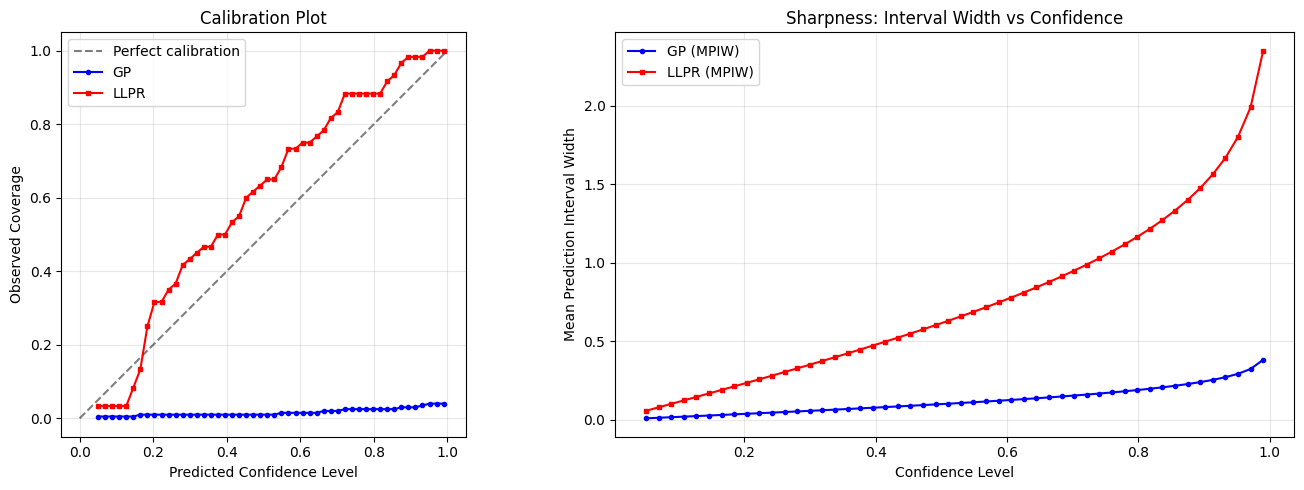

In [17]:
# Calibration plot: predicted confidence level vs observed coverage
from scipy.stats import norm

confidence_levels = np.linspace(0.05, 0.99, 50)
z_values = norm.ppf((1 + confidence_levels) / 2)

gp_observed = []
llpr_observed = []
for z in z_values:
    gp_residuals = np.abs(y_gp_test.ravel() - y_gp_pred) / y_gp_std
    gp_observed.append(np.mean(gp_residuals < z))
    
    llpr_residuals = np.abs(y_te.ravel() - y_llpr_pred_te) / y_llpr_std_te
    llpr_observed.append(np.mean(llpr_residuals < z))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Calibration plot
ax = axes[0]
ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect calibration')
ax.plot(confidence_levels, gp_observed, 'b-o', markersize=3, label='GP')
ax.plot(confidence_levels, llpr_observed, 'r-s', markersize=3, label='LLPR')
ax.set_xlabel('Predicted Confidence Level')
ax.set_ylabel('Observed Coverage')
ax.set_title('Calibration Plot')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

# Sharpness comparison (interval widths at different confidence levels)
ax = axes[1]
gp_widths = [2 * z * np.mean(y_gp_std) for z in z_values]
llpr_widths = [2 * z * np.mean(y_llpr_std_te) for z in z_values]
ax.plot(confidence_levels, gp_widths, 'b-o', markersize=3, label='GP (MPIW)')
ax.plot(confidence_levels, llpr_widths, 'r-s', markersize=3, label='LLPR (MPIW)')
ax.set_xlabel('Confidence Level')
ax.set_ylabel('Mean Prediction Interval Width')
ax.set_title('Sharpness: Interval Width vs Confidence')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Assumptions and When UQ Breaks

Uncertainty estimates are only as good as the assumptions behind them. Before trusting any confidence interval, check these:

### Normality

Most interval methods assume Gaussian (normal) residuals. When residuals are skewed or heavy-tailed, predicted intervals may undercover. **Check with a Q-Q plot** of residuals.

### Homoscedasticity

Standard methods assume constant variance across the input range. If variance changes with x (heteroscedasticity), a single sigma underestimates uncertainty in high-variance regions and overestimates in low-variance regions.

### Independence

Observations must be independent. Time-series data, spatial data, or repeated measurements from the same experiment violate this. Correlated residuals make confidence intervals too narrow.

### Model Specification

If the model is structurally wrong (e.g., fitting a line to quadratic data), parameter confidence intervals are meaningless—they're precise estimates of the wrong thing. **Always check residual plots for patterns.**

**Key message:** *Always check assumptions before trusting uncertainty estimates.* A narrow confidence interval from a misspecified model is worse than no interval at all—it gives false confidence.

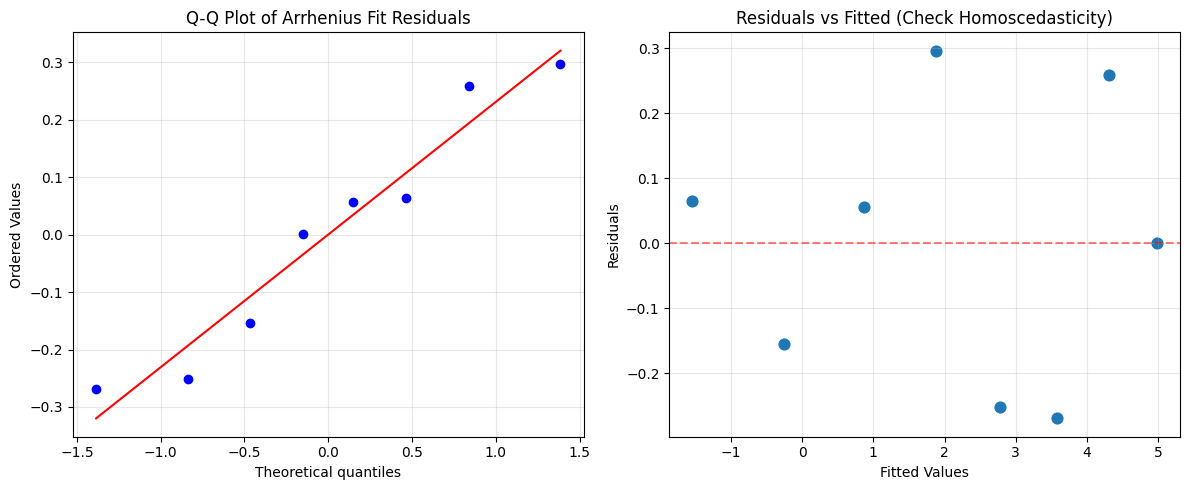

In [18]:
# Q-Q plot of residuals from the Arrhenius linear regression
from scipy import stats

residuals_arr = ln_k - X @ model_lr.coefs_

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Q-Q plot
ax = axes[0]
stats.probplot(residuals_arr, dist="norm", plot=ax)
ax.set_title('Q-Q Plot of Arrhenius Fit Residuals')
ax.grid(True, alpha=0.3)

# Residuals vs fitted values (check homoscedasticity)
ax = axes[1]
fitted = X @ model_lr.coefs_
ax.scatter(fitted, residuals_arr, s=60)
ax.axhline(y=0, color='r', linestyle='--', alpha=0.5)
ax.set_xlabel('Fitted Values')
ax.set_ylabel('Residuals')
ax.set_title('Residuals vs Fitted (Check Homoscedasticity)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

```{index} uncertainty propagation, Monte Carlo simulation, uncertainties package
```


## Uncertainty Propagation: How Errors Compound

When inputs have uncertainty, outputs have uncertainty too. But how much?

### Two Approaches

| Method | How It Works | When to Use |
|--------|--------------|-------------|
| **Analytical** | Taylor expansion, linear approximation | Simple functions, small uncertainties |
| **Monte Carlo** | Sample inputs, compute outputs, analyze distribution | Complex functions, any uncertainty size |

### The uncertainties Package

For analytical propagation, the `uncertainties` package is elegant. Define uncertain numbers, and it automatically tracks how uncertainty flows through calculations.

```python
T = ufloat(400, 5)  # 400 ± 5
P = ufloat(10, 1)   # 10 ± 1
result = P / T      # Automatically tracks uncertainty!
```

### When Monte Carlo Is Necessary

Analytical propagation assumes small, symmetric uncertainties. Use Monte Carlo when:
- Uncertainties are large
- Distributions are non-normal (e.g., uniform, log-normal)
- Functions are highly nonlinear
- You need the full output distribution, not just mean ± std

In [20]:
# Using the uncertainties package (commonly used with pycse)
from uncertainties import ufloat
from uncertainties import umath

# Define uncertain quantities
T = ufloat(400, 5)     # Temperature: 400 ± 5 K
P = ufloat(10, 0.5)    # Pressure: 10 ± 0.5 bar
R = 8.314              # Gas constant (exact)

# Ideal gas: n/V = P/(RT)
# Convert P to Pa: P * 1e5
concentration = (P * 1e5) / (R * T)

print("Uncertainty Propagation Example:")
print(f"  Temperature: {T}")
print(f"  Pressure: {P} bar")
print(f"  Concentration: {concentration:.2f} mol/m³")

Uncertainty Propagation Example:
  Temperature: 400+/-5
  Pressure: 10.0+/-0.5 bar
  Concentration: 300.70+/-15.50 mol/m³


In [ ]:
# Arrhenius equation with uncertain parameters
A = ufloat(1.2e8, 0.3e8)       # Pre-exponential factor
Ea = ufloat(52000, 2000)       # Activation energy (J/mol)
T = ufloat(450, 10)            # Temperature (K)
R = 8.314

# k = A * exp(-Ea/(R*T))
k = A * umath.exp(-Ea / (R * T))

print("Arrhenius Rate Constant:")
print(f"  A = {A}")
print(f"  Ea = {Ea} J/mol")
print(f"  T = {T} K")
print(f"  k = {k:.2e}")

Arrhenius Rate Constant:
  A = (1.20+/-0.30)e+08
  Ea = (5.20+/-0.20)e+04 J/mol
  T = 450+/-10 K
  k = (1.10+/-0.74)e+02


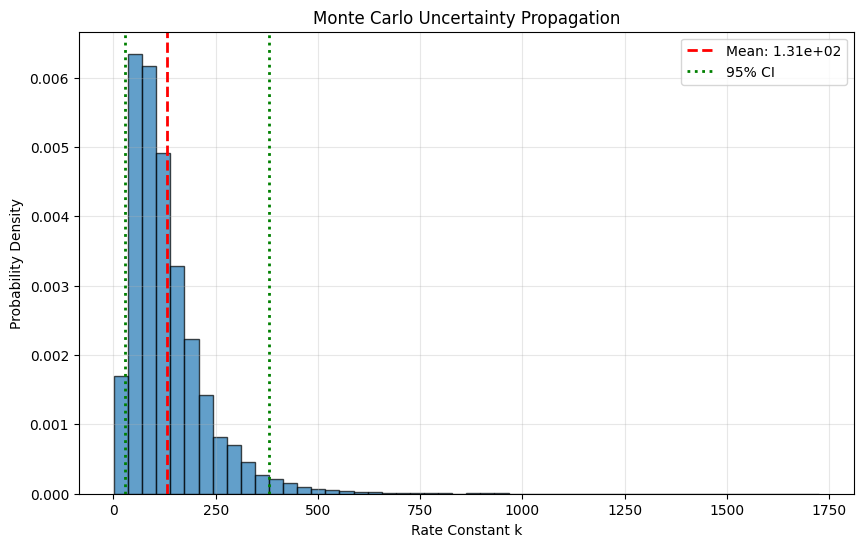

Monte Carlo Results:
  Mean k: 1.309e+02
  Std k: 9.727e+01
  95% CI: [2.723e+01, 3.814e+02]


In [ ]:
# Monte Carlo uncertainty propagation
np.random.seed(42)
n_samples = 10000

# Sample from distributions
A_samples = np.random.normal(1.2e8, 0.3e8, n_samples)
Ea_samples = np.random.normal(52000, 2000, n_samples)
T_samples = np.random.normal(450, 10, n_samples)

# Calculate k for each sample
k_samples = A_samples * np.exp(-Ea_samples / (8.314 * T_samples))

plt.figure(figsize=(10, 6))
plt.hist(k_samples, bins=50, density=True, alpha=0.7, edgecolor='black')
plt.axvline(x=np.mean(k_samples), color='r', linestyle='--', linewidth=2, label=f'Mean: {np.mean(k_samples):.2e}')
plt.axvline(x=np.percentile(k_samples, 2.5), color='g', linestyle=':', linewidth=2)
plt.axvline(x=np.percentile(k_samples, 97.5), color='g', linestyle=':', linewidth=2, label='95% CI')
plt.xlabel('Rate Constant k')
plt.ylabel('Probability Density')
plt.title('Monte Carlo Uncertainty Propagation')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Monte Carlo Results:")
print(f"  Mean k: {np.mean(k_samples):.3e}")
print(f"  Std k: {np.std(k_samples):.3e}")
print(f"  95% CI: [{np.percentile(k_samples, 2.5):.3e}, {np.percentile(k_samples, 97.5):.3e}]")

In [ ]:
%pip install -q jupyterquiz
from jupyterquiz import display_quiz

display_quiz("https://raw.githubusercontent.com/jkitchin/s26-06642/main/dsmles/12-uncertainty-quantification/quizzes/uncertainty-quantification-quiz.json")

/bin/bash: pip: command not found


<IPython.core.display.Javascript object>

## Recommended Reading

These resources cover uncertainty quantification methods and best practices:

1. **[pycse Documentation](https://kitchingroup.cheme.cmu.edu/pycse/)** - Documentation for the pycse library used in this course. Covers regress, nlinfit, and other uncertainty-aware fitting functions.

2. **[Scikit-learn Gaussian Processes](https://scikit-learn.org/stable/modules/gaussian_process.html)** - Official documentation on GP regression and classification. Includes guidance on kernel selection and hyperparameter optimization.

3. **[A Visual Exploration of Gaussian Processes (Görtler et al.)](https://distill.pub/2019/visual-exploration-gaussian-processes/)** - An interactive Distill article that builds intuition for how Gaussian Processes work. Excellent visualizations of kernels and uncertainty.

4. **[Uncertainties Package Documentation](https://pythonhosted.org/uncertainties/)** - Documentation for the uncertainties library for automatic error propagation. Shows how to track uncertainty through complex calculations.

5. **[NIST/SEMATECH Uncertainty Guide](https://www.itl.nist.gov/div898/handbook/mpc/mpc.htm)** - Comprehensive guide to measurement uncertainty from NIST. Covers propagation of uncertainty, Type A and B evaluations, and reporting standards.

6. **[Bigi et al. (2024) - Prediction Rigidity](https://arxiv.org/abs/2207.02025)** - The theoretical foundation for Last-Layer Prediction Rigidity (LLPR), which provides calibrated uncertainty estimates from neural networks by analyzing the covariance structure of last-layer features.

## Summary: Uncertainty Quantification Toolkit

### When to Use What

| Situation | Recommended Method |
|-----------|-------------------|
| Linear regression parameters | `pycse.regress` |
| Linear regression in sklearn pipelines | `LinearRegressionUQ` |
| Nonlinear fitting parameters | `pycse.nlinfit` |
| Neural network with uncertainty | `LLPRRegressor` |
| Predictions with honest uncertainty | Gaussian Processes |
| Simple error propagation | `uncertainties` package |
| Complex or large uncertainties | Monte Carlo simulation |
| Checking if UQ is trustworthy | Calibration, PICP, MPIW metrics |

### Key Takeaways

1. **Always report uncertainty**: A prediction without confidence limits is incomplete
2. **Confidence intervals ≠ prediction intervals**: Parameter uncertainty ≠ outcome uncertainty
3. **GPs grow uncertain far from data**: This is a feature, not a bug
4. **Propagate uncertainty through calculations**: Inputs uncertain → outputs uncertain
5. **Use Monte Carlo for complex cases**: When in doubt, sample
6. **Evaluate your UQ**: Check calibration before trusting uncertainty estimates
7. **Check assumptions**: Normality, homoscedasticity, independence, and model specification

### The Engineering Mindset

In research, we seek the "true" value. In engineering, we design for the worst case. Understanding uncertainty lets you:
- Set appropriate safety factors
- Make robust decisions
- Plan experiments efficiently
- Communicate confidence honestly

### Common Pitfalls

- Ignoring model uncertainty (only reporting parameter uncertainty)
- Assuming normal distributions when data suggests otherwise
- Over-interpreting GP uncertainty far from training data
- Forgetting to propagate uncertainty to final decisions
- Trusting narrow confidence intervals from a misspecified model

## Next Steps

In the final module, we'll learn about model interpretability—understanding *why* models make their predictions, not just what they predict.

---

## The Catalyst Crisis: Chapter 12 - "What We Don't Know"

*A story about uncertainty, honesty, and building trust*

---

"You're recommending we reject 40% of incoming catalyst lots."

The ChemCorp VP of Operations had joined the call—someone none of them had met before. Senior enough to make decisions. Skeptical enough to question everything.

"Based on the clustering model, yes," Alex said.

"That's a $2 million annual cost. You're sure?"

The question hung in the air. Was she sure? Her model had 0.92 R-squared. Her clusters were statistically significant. The evidence pointed clearly at the catalyst.

But *sure*?

"I'd like to show you the uncertainty in our predictions," Alex said.

She pulled up the Gaussian Process model she'd built as a complement to the Random Forest. Unlike the forest, the GP provided confidence intervals—not just predictions, but estimates of how confident those predictions were.

"For batches using Cluster 1 catalyst, our predictions are tight. 95% confidence interval of plus or minus 3% yield." She clicked to the next plot. "For Cluster 3 catalyst, the confidence interval is plus or minus 12%."

The VP frowned. "So you're less certain about the bad catalyst?"

"We have less data from those conditions. The model knows what it doesn't know." Alex highlighted the uncertainty bands. "If you want to reduce this uncertainty, you could run controlled experiments—deliberately use some Cluster 3 catalyst under carefully monitored conditions."

"You're suggesting we intentionally run bad batches?"

"I'm suggesting you could learn more with a few planned experiments than with months of observational data. Right now, we're confident that Cluster 3 is worse. We're less confident about exactly how much worse, or whether operating conditions could compensate."

The room was quiet. This wasn't the clear answer they wanted. But it was the honest answer.

The VP surprised her. "I appreciate that. Too many consultants pretend to certainty they don't have." He leaned back. "We'll start with screening—reject the obvious Cluster 3 lots. And we'll design an experiment for the borderline cases. Your team will help?"

"Absolutely."

After the call, Jordan found Alex at her desk, staring at the uncertainty plots.

"That was brave. Telling an executive you're not sure."

Alex shrugged. "I was sure about what I was sure about. And honest about what I wasn't. That's all we can do."

She added to the mystery board: **Uncertainty is information. High confidence in Cluster 1 recommendations. Lower confidence in Cluster 3—need controlled experiments.**

---

*Continue to the final lecture for the resolution of the Catalyst Crisis...*